# Introducción

El banco Beta Bank luego de un análisis exautivo llegó a la conclusión de que es mas rentable mantener antiguos clientes que conseguir nuevas afiliaciones. Por este motivo se nos solicitó desarrollar un modelo de machine learning que pueda predecir la cantidad de clientes que abandonarán el banco en base a la información histórica del comportamiento de cada cliente, la cual ha sido proporcionada por la entidad financiera.

A continuación detallaremos paso a paso el desarrollo del modelo de machine learning solicitado y además de el proceso de afinamiento con el objetivo de llegar a métricas razonables que lleven a nivel de predicción esperado.

# Inicialización 

In [27]:
# Importamos las librerías necesarias

import pandas as pd
import matplotlib.pyplot as plt
from re import sub
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV



# Carga de datos

In [28]:
# Cargamos los datos
try:
    churn_df = pd.read_csv("/datasets/Churn.csv")
except:
    churn_df = pd.read_csv("Churn.csv")

In [29]:
# Visualizamos los datos
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


# Preparación de datos

In [30]:
# Cambiamos el formato de la columnas a tipo snake_case. 

def snake_case(s):
    return '_'.join(
        sub('([A-Z][a-z]+)', r' \1',
        sub('([A-Z]+)', r' \1',
        s.replace('-', ' '))).split()).lower()

columnas= []
for column in churn_df.columns:
    columnas.append(snake_case(column))
churn_df.columns = columnas

In [31]:
churn_df.head(10)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [32]:
# Eliminamos las columnas que no aportan valor al aprendizaje

cl_churn_df = churn_df.drop(['row_number','customer_id','surname'], axis= 1)
cl_churn_df.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [33]:
# Transformamos la variable num_of_products en una variable tipo string para poder hacer una codificación ohe.
cl_churn_df['num_of_products'] = cl_churn_df['num_of_products'].astype(str) 

**Conclusiones:**

Los tipos de datos del conjunto de datos son correctos, sin embargo tenemos valores nulos para la variable 'Tenure', la cual será imputada con la media agrupada por la edad.

In [34]:
# Dividimos el conjunto de datos en conjunto de datos en features y target.

x = cl_churn_df.drop(columns= 'exited')
y = cl_churn_df['exited']

In [35]:
# Dividimos los conjuntos de datos en entrenamiento, validación y prueba.

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size= 0.40, random_state= 42)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size= 0.50, random_state= 42)

print(f'train x: {x_train.shape}, train y: {y_train.shape}')
print(f'valid x: {x_valid.shape}, valid y: {y_valid.shape}')
print(f'test x: {x_test.shape}, test y: {y_test.shape}')

train x: (6000, 10), train y: (6000,)
valid x: (2000, 10), valid y: (2000,)
test x: (2000, 10), test y: (2000,)


## Preparación conjunto de datos para regresión logística

In [36]:
# Aplicamos OHE a los conjuntos de datos

x_train_ohe = pd.get_dummies(x_train, drop_first= True)
x_valid_ohe = pd.get_dummies(x_valid, drop_first= True)
x_test_ohe = pd.get_dummies(x_test, drop_first= True)

x_test_ohe.head()

,credit_score,age,tenure,balance,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male,num_of_products_2,num_of_products_3,num_of_products_4
7072,686,37,9.0,134560.62,1,0,27596.39,0,0,1,0,0,0
6204,498,33,1.0,198113.86,1,0,69664.35,0,0,1,0,0,0
7110,679,28,9.0,0.00,0,1,61761.77,0,1,0,1,0,0
220,726,31,9.0,114722.05,1,1,98178.57,0,0,0,1,0,0
69,675,21,8.0,98373.26,1,0,18203.00,0,0,0,0,0,0


In [37]:
x_test_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 7072 to 964
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       2000 non-null   int64  
 1   age                2000 non-null   int64  
 2   tenure             1815 non-null   float64
 3   balance            2000 non-null   float64
 4   has_cr_card        2000 non-null   int64  
 5   is_active_member   2000 non-null   int64  
 6   estimated_salary   2000 non-null   float64
 7   geography_Germany  2000 non-null   uint8  
 8   geography_Spain    2000 non-null   uint8  
 9   gender_Male        2000 non-null   uint8  
 10  num_of_products_2  2000 non-null   uint8  
 11  num_of_products_3  2000 non-null   uint8  
 12  num_of_products_4  2000 non-null   uint8  
dtypes: float64(3), int64(4), uint8(6)
memory usage: 136.7 KB


In [38]:
# Imputamos los valores ausentes con la 'media' de la variable.

si = SimpleImputer(strategy= 'median')

x_train_ohe_imp = pd.DataFrame(si.fit_transform(x_train_ohe), columns= x_train_ohe.columns)
x_valid_ohe_imp = pd.DataFrame(si.transform(x_valid_ohe), columns= x_valid_ohe.columns)
x_test_ohe_imp= pd.DataFrame(si.transform(x_test_ohe), columns= x_test_ohe.columns)

# Validamos que ya no hayan valores nulos
print(x_train_ohe_imp.isnull().sum().sum(), x_valid_ohe_imp.isnull().sum().sum(), x_test_ohe_imp.isnull().sum().sum())

0 0 0


In [39]:
# Estandarizamos el conjunto de datos.

numeric = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']

sc = StandardScaler()
x_train_ohe_imp[numeric] = sc.fit_transform(x_train_ohe_imp[numeric])
x_valid_ohe_imp[numeric] = sc.transform(x_valid_ohe_imp[numeric])
x_test_ohe_imp[numeric] = sc.transform(x_test_ohe_imp[numeric])

x_train_ohe_imp.head()

,credit_score,age,tenure,balance,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male,num_of_products_2,num_of_products_3,num_of_products_4
0,1.603068,2.027653,0.012657,-0.048229,1.0,1.0,-1.452982,1.0,0.0,0.0,1.0,0.0,0.0
1,1.883194,-1.520072,-0.348962,0.884122,1.0,0.0,-1.403696,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.451185,0.014079,1.097514,1.050751,0.0,1.0,1.290549,0.0,0.0,0.0,0.0,0.0,0.0
3,0.243941,-1.232419,-1.433820,0.517839,0.0,0.0,-0.709924,1.0,0.0,0.0,0.0,0.0,0.0
4,-1.416062,-0.561228,-0.710582,-1.214721,1.0,1.0,-0.736719,0.0,1.0,0.0,1.0,0.0,0.0


In [40]:
x_train_ohe_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       6000 non-null   float64
 1   age                6000 non-null   float64
 2   tenure             6000 non-null   float64
 3   balance            6000 non-null   float64
 4   has_cr_card        6000 non-null   float64
 5   is_active_member   6000 non-null   float64
 6   estimated_salary   6000 non-null   float64
 7   geography_Germany  6000 non-null   float64
 8   geography_Spain    6000 non-null   float64
 9   gender_Male        6000 non-null   float64
 10  num_of_products_2  6000 non-null   float64
 11  num_of_products_3  6000 non-null   float64
 12  num_of_products_4  6000 non-null   float64
dtypes: float64(13)
memory usage: 609.5 KB


## Preparación de datos para modelo de árboles

In [41]:
x_train.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
9761,807,Germany,Female,60,NaN,72948.58,2,1,1,17355.36
3159,834,France,Male,23,4.0,131254.81,1,1,0,20199.30
1489,609,France,Female,39,8.0,141675.23,1,0,1,175664.25
2987,676,Germany,Female,26,1.0,108348.66,1,0,0,60231.74
812,516,Spain,Female,33,3.0,0.00,2,1,1,58685.59


In [42]:
# Imputamos los valores ausentes con la 'media' de la variable.

si = SimpleImputer(strategy= 'median')

tenure_x_train = pd.DataFrame(si.fit_transform(x_train[['tenure']]), columns= ['tenure'])
tenure_x_valid = pd.DataFrame(si.transform(x_valid[['tenure']]), columns= ['tenure'])
tenure_x_test = pd.DataFrame(si.transform(x_test[['tenure']]), columns= ['tenure'])

x_train_imp = pd.concat([x_train.drop(columns = "tenure").reset_index(drop = True), tenure_x_train], axis = 1)
x_valid_imp = pd.concat([x_valid.drop(columns = "tenure").reset_index(drop = True), tenure_x_valid], axis = 1)
x_test_imp = pd.concat([x_test.drop(columns = "tenure").reset_index(drop = True), tenure_x_test], axis = 1)

# Validamos que ya no hayan valores nulos
print(x_train_imp.isnull().sum().sum(), x_valid_imp.isnull().sum().sum(), x_test_imp.isnull().sum().sum())

0 0 0


In [43]:
# Aplicamos Ordinal encoder al conjunto de datos

oe = OrdinalEncoder()
geo_gen_x_train = pd.DataFrame(oe.fit_transform(x_train_imp[['geography', 'gender']]), columns= ['geography','gender'])
geo_gen_x_valid = pd.DataFrame(oe.transform(x_valid_imp[['geography', 'gender']]), columns= ['geography','gender'])
geo_gen_x_test = pd.DataFrame(oe.transform(x_test_imp[['geography', 'gender']]), columns= ['geography','gender'])

x_train_ord = pd.concat([x_train_imp.drop(columns= ['geography','gender']).reset_index(drop= True), geo_gen_x_train], axis= 1)
x_valid_ord = pd.concat([x_valid_imp.drop(columns= ['geography','gender']).reset_index(drop= True), geo_gen_x_valid], axis= 1)
x_test_ord = pd.concat([x_test_imp.drop(columns= ['geography','gender']).reset_index(drop= True), geo_gen_x_test], axis= 1)

x_train_ord.head(10)

,credit_score,age,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,tenure,geography,gender
0,807,60,72948.58,2,1,1,17355.36,5.0,1.0,0.0
1,834,23,131254.81,1,1,0,20199.30,4.0,0.0,1.0
2,609,39,141675.23,1,0,1,175664.25,8.0,0.0,0.0
3,676,26,108348.66,1,0,0,60231.74,1.0,1.0,0.0
4,516,33,0.00,2,1,1,58685.59,3.0,2.0,0.0
5,831,30,0.00,2,0,1,3430.38,2.0,0.0,1.0
6,748,32,154737.88,2,1,1,172638.13,5.0,0.0,1.0
7,580,24,133811.78,1,1,0,17185.95,1.0,1.0,1.0
8,735,28,160454.15,2,0,1,114957.22,5.0,1.0,1.0
9,531,31,117052.82,1,1,0,118508.09,7.0,1.0,0.0


In [44]:
# Aplicamos codificación ohe a la variable 'num_of_products'

x_train_ord = pd.get_dummies(x_train_ord, drop_first= True)
x_valid_ord = pd.get_dummies(x_valid_ord, drop_first= True)
x_test_ord = pd.get_dummies(x_test_ord, drop_first= True)

x_train_ord.head()

,credit_score,age,balance,has_cr_card,is_active_member,estimated_salary,tenure,geography,gender,num_of_products_2,num_of_products_3,num_of_products_4
0,807,60,72948.58,1,1,17355.36,5.0,1.0,0.0,1,0,0
1,834,23,131254.81,1,0,20199.30,4.0,0.0,1.0,0,0,0
2,609,39,141675.23,0,1,175664.25,8.0,0.0,0.0,0,0,0
3,676,26,108348.66,0,0,60231.74,1.0,1.0,0.0,0,0,0
4,516,33,0.00,1,1,58685.59,3.0,2.0,0.0,1,0,0


In [45]:
# Estandarizamos el conjunto de datos.

numeric = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']

sc = StandardScaler()
x_train_ord[numeric] = sc.fit_transform(x_train_ord[numeric])
x_valid_ord[numeric] = sc.transform(x_valid_ord[numeric])
x_test_ord[numeric] = sc.transform(x_test_ord[numeric])

x_train_ord.head()

,credit_score,age,balance,has_cr_card,is_active_member,estimated_salary,tenure,geography,gender,num_of_products_2,num_of_products_3,num_of_products_4
0,1.603068,2.027653,-0.048229,1,1,-1.452982,0.012657,1.0,0.0,1,0,0
1,1.883194,-1.520072,0.884122,1,0,-1.403696,-0.348962,0.0,1.0,0,0,0
2,-0.451185,0.014079,1.050751,0,1,1.290549,1.097514,0.0,0.0,0,0,0
3,0.243941,-1.232419,0.517839,0,0,-0.709924,-1.433820,1.0,0.0,0,0,0
4,-1.416062,-0.561228,-1.214721,1,1,-0.736719,-0.710582,2.0,0.0,1,0,0


# Equilibrio de clases

In [46]:
# Analizamos si esxiste un desequilibrio de clases.
y_train.value_counts(normalize= True)

0    0.7955
1    0.2045
Name: exited, dtype: float64

**Conclusión:**

El conjunto de datos tiene un fuerte desequilibrio de clases vamos a entrenar el modelo obteniendo racall y precision para validar como afecta.

Entrenamos modelos sin atender el problema de desequilibrio para sacar conclusiones.


In [47]:
x_train_ohe_imp.head()

,credit_score,age,tenure,balance,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male,num_of_products_2,num_of_products_3,num_of_products_4
0,1.603068,2.027653,0.012657,-0.048229,1.0,1.0,-1.452982,1.0,0.0,0.0,1.0,0.0,0.0
1,1.883194,-1.520072,-0.348962,0.884122,1.0,0.0,-1.403696,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.451185,0.014079,1.097514,1.050751,0.0,1.0,1.290549,0.0,0.0,0.0,0.0,0.0,0.0
3,0.243941,-1.232419,-1.433820,0.517839,0.0,0.0,-0.709924,1.0,0.0,0.0,0.0,0.0,0.0
4,-1.416062,-0.561228,-0.710582,-1.214721,1.0,1.0,-0.736719,0.0,1.0,0.0,1.0,0.0,0.0


In [48]:
# Entrenamos un modelo de regresión logística.

modelo_rl = LogisticRegression(solver= 'liblinear', random_state= 42)
modelo_rl.fit(x_train_ohe_imp, y_train)
predicted_y = modelo_rl.predict(x_valid_ohe_imp)

print('matriz de confusion: \n', confusion_matrix(y_valid, predicted_y))
print('Train accuracy:', modelo_rl.score(x_train_ohe_imp, y_train))
print('Valid accuracy: ',accuracy_score(y_valid, predicted_y))
print('precision: ',precision_score(y_valid, predicted_y))
print('recall: ',recall_score(y_valid, predicted_y))
print('F1: ', f1_score(y_valid, predicted_y))

matriz de confusion: 
 [[1555   65]
 [ 241  139]]
Train accuracy: 0.842
Valid accuracy:  0.847
precision:  0.6813725490196079
recall:  0.36578947368421055
F1:  0.476027397260274


In [49]:
# Entrenamos un modelo de arbol de decisiones.

modelo_dt = DecisionTreeClassifier(random_state= 42)
modelo_dt.fit(x_train_ord, y_train)
predicted_y = modelo_dt.predict(x_valid_ord)

print('matriz de confusion: \n', confusion_matrix(y_valid, predicted_y))
print('Train accuracy:', modelo_dt.score(x_train_ord, y_train))
print('accuracy: ',accuracy_score(y_valid, predicted_y))
print('precision: ',precision_score(y_valid, predicted_y))
print('recall: ',recall_score(y_valid, predicted_y))
print('F1: ', f1_score(y_valid, predicted_y))

matriz de confusion: 
 [[1397  223]
 [ 194  186]]
Train accuracy: 1.0
accuracy:  0.7915
precision:  0.4547677261613692
recall:  0.48947368421052634
F1:  0.47148288973384034


In [50]:
# Entrenamos un modelo Bosque Aleatoreo.

modelo_rf = RandomForestClassifier(random_state= 42)
modelo_rf.fit(x_train_ord, y_train)
predicted_y = modelo_rf.predict(x_valid_ord)

print('matriz de confusion: \n', confusion_matrix(y_valid, predicted_y))
print('Train accuracy:', modelo_rf.score(x_train_ord, y_train))
print('accuracy: ',accuracy_score(y_valid, predicted_y))
print('precision: ',precision_score(y_valid, predicted_y))
print('recall: ',recall_score(y_valid, predicted_y))
print('F1: ', f1_score(y_valid, predicted_y))

matriz de confusion: 
 [[1556   64]
 [ 210  170]]
Train accuracy: 1.0
accuracy:  0.863
precision:  0.7264957264957265
recall:  0.4473684210526316
F1:  0.5537459283387622


**Conclusiones:**

- En el modelo de regresión logística podemos encontrar que no hay sobreajuste y el puntaje para la exactitud y precisión son buenos, 0.84 y 0.68 respectivamente, sin embargo en la sensibilidad es baja, tan solo de 0.37 lo que afecta directamente a la métrica f1 que es de 0.48.


- En el modelo de arbol de decisión podemos encontrar sobreajuste ya que el puntaje con el conjunto de entrenamiento es de 1.0 y con el puntaje de validación es de 0.79, también podemos observar que para la precisión, recall y f1 los puntajes son mucho mejores que el modelo de regresión, 0.46, 0.47 y 0.47 respectivamente.


- Al igual que el arbol de decisión en el bosque aleatorio, encontramos sobreajuste pero menos que en el arbol de decisión. Este modelo hasta el momento ha dado los mejores resultados, con una precisión de 0.72, una sencibilidad de 0.44 y un f1 de 0.55. 



# Mejoramiento de modelos 

## Mejoramiento desbalanceo

In [51]:
# Ajustamos el peso de las clases

forest_model = RandomForestClassifier(random_state= 42, class_weight= 'balanced')
forest_model.fit(x_train_ord, y_train)
valid_predictions = forest_model.predict(x_valid_ord)
#score = forest_model.score(x_valid_ord, valid_ordinal_y)

print('La exactitud es:', accuracy_score(y_valid, valid_predictions))
print('La precision es:', precision_score(y_valid, valid_predictions))
print('El recall es:', recall_score(y_valid, valid_predictions))
print('F1 es:', f1_score(y_valid, valid_predictions))

La exactitud es: 0.856
La precision es: 0.7090909090909091
El recall es: 0.4105263157894737
F1 es: 0.52


**Conclusiones:**

Luego de realizar un balanceo de clases mediante el parámtro "class_weight" = balanced, el modelo arrojó peores resultados. 

In [52]:
x_train_ord.shape

(6000, 12)

In [53]:
y_train.reset_index(drop= True).shape

(6000,)

In [54]:
# Mejoramos el desbalncéo realizando un sobremuestreo.

# Definimos una función que aumenta la cantidad clientes que abandonan el banco, en otras palabras aumentamos los "1".

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42
    )

    return features_upsampled, target_upsampled

x_train_upsampled, y_train_upsampled = upsample(x_train_ord, y_train.reset_index(drop= True), 4)

forest_model = RandomForestClassifier(random_state= 42)
forest_model.fit(x_train_upsampled, y_train_upsampled)
valid_predictions = forest_model.predict(x_valid_ord)

print('La exactitud es:', accuracy_score(y_valid, valid_predictions))
print('La precision es:', precision_score(y_valid, valid_predictions))
print('El recall es:', recall_score(y_valid, valid_predictions))
print('F1 es:', f1_score(y_valid, valid_predictions))

La exactitud es: 0.845
La precision es: 0.6086956521739131
El recall es: 0.5157894736842106
F1 es: 0.5584045584045585


**Conclusiones:**

El sobremuestreo a ha equilibrado de mejor manera la precisión con la sensibilidad, a pesar de que la métrica f1 es la misma se considera un mejora ya que ambas métricas sensibilidad y precisión están mas equilibradas.

## Mejoramiento modificando hiperparámetros

In [55]:
# Buscamos los mejores parámetros para el modelo de entrenamiento utilizando GridSearchCV, también utilizamos el conjunto al 
#cual le aplicamos sobremuestreo ya que dió mejores result

param_grid = {
    'n_estimators': list(range(100, 200, 10)),
    'max_depth': list(range(1,20, 1)),
    'random_state': [42]
}

grid = GridSearchCV(RandomForestClassifier(), scoring= 'f1', param_grid= param_grid)
grid.fit(x_train_upsampled, y_train_upsampled)

print('El mejor puntaje es: ', grid.best_score_)
print('Los mejores parámetrod son: ', grid.best_params_)

El mejor puntaje es:  0.9559405729028294
Los mejores parámetrod son:  {'max_depth': 19, 'n_estimators': 170, 'random_state': 42}


In [56]:
# Aplicamos los mejores parámetros para el cojunto de validación.
grid_predictions = grid.predict(x_valid_ord)

print('f1:', f1_score(y_valid, grid_predictions))

f1: 0.5583333333333335


In [57]:
results_df = pd.DataFrame(grid.cv_results_)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.230253,0.010027,0.020527,0.001028,1,100,42,"{'max_depth': 1, 'n_estimators': 100, 'random_...",0.735141,0.723810,0.735608,0.762154,0.748306,0.741004,0.013113,189
1,0.249520,0.010791,0.021070,0.000179,1,110,42,"{'max_depth': 1, 'n_estimators': 110, 'random_...",0.739769,0.729122,0.720701,0.763830,0.747114,0.740107,0.014895,190
2,0.267995,0.007269,0.023141,0.000942,1,120,42,"{'max_depth': 1, 'n_estimators': 120, 'random_...",0.736067,0.728342,0.731311,0.763424,0.746457,0.741120,0.012735,188
3,0.284420,0.005430,0.024817,0.000920,1,130,42,"{'max_depth': 1, 'n_estimators': 130, 'random_...",0.736731,0.728632,0.731998,0.768908,0.747114,0.742677,0.014522,187
4,0.304344,0.007066,0.025890,0.000699,1,140,42,"{'max_depth': 1, 'n_estimators': 140, 'random_...",0.740701,0.733261,0.737854,0.783686,0.761310,0.751363,0.018802,184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,1.138584,0.019713,0.063008,0.000006,19,150,42,"{'max_depth': 19, 'n_estimators': 150, 'random...",0.951447,0.960861,0.952288,0.953353,0.956607,0.954911,0.003452,5
186,1.215559,0.011468,0.067804,0.001166,19,160,42,"{'max_depth': 19, 'n_estimators': 160, 'random...",0.950980,0.962273,0.951825,0.952890,0.958944,0.955383,0.004437,3
187,1.300058,0.033831,0.071605,0.002059,19,170,42,"{'max_depth': 19, 'n_estimators': 170, 'random...",0.951914,0.962745,0.952752,0.953816,0.958476,0.955941,0.004090,1
188,1.356258,0.022518,0.074603,0.001019,19,180,42,"{'max_depth': 19, 'n_estimators': 180, 'random...",0.951914,0.961802,0.951825,0.954280,0.958008,0.955566,0.003843,2


C:\Users\Usuario\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


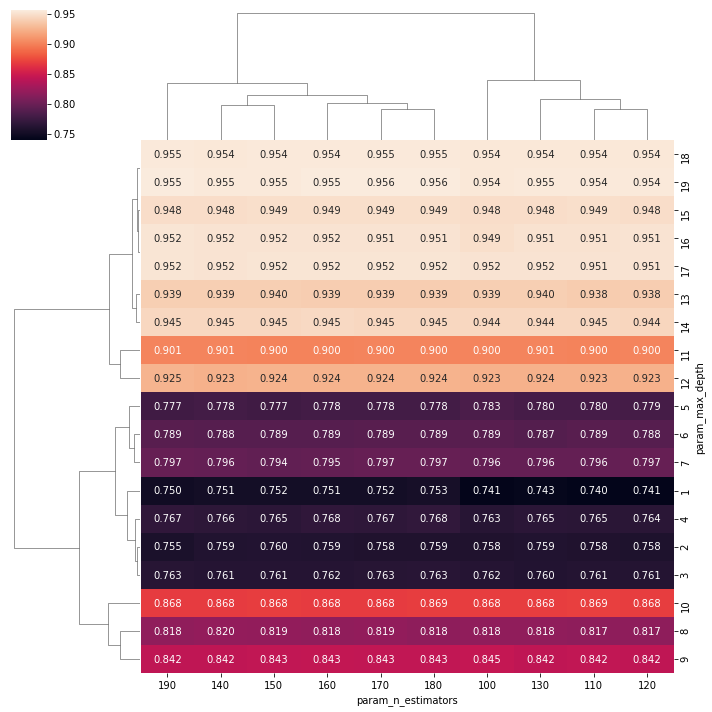

In [58]:
# Visualizamos en un hetmap donde podría estar los mjores hiperparámetros.
hp_search = results_df[["param_max_depth","param_n_estimators","mean_test_score"]].pivot(index = "param_max_depth", columns = "param_n_estimators", values = "mean_test_score")
sns.clustermap(hp_search, annot = True, fmt = ".3f");

**Conclusiones:**

Lastimosamente el modelo encontrado con los parámetros propuestos por el GridSearchCV está sobre ajustado. 

In [59]:
# Buscamos con un bucle los mejores parámetros para el conjunto de validación.
best_score = 0
best_depth = 0
best_est = None

for depth in range(12, 18):
    for est in range(100, 200):
            forest_model = RandomForestClassifier(n_estimators= est, max_depth= depth, random_state= 42)
            forest_model.fit(x_train_upsampled, y_train_upsampled)
            valid_predictions = forest_model.predict(x_valid_ord)
            score = f1_score(y_valid, valid_predictions)

            if (score > best_score):
                best_score = score
                best_depth = depth
                best_est = est
        
print('El mejor score es:', best_score)
print('El mejor depth es:', best_depth)
print('El mejor estimador es:', best_est)

El mejor score es: 0.5833333333333334
El mejor depth es: 14
El mejor estimador es: 195


In [60]:
# Buscamos con un bucle los mejores parámetros para el conjunto de validación.
best_score = 0
best_depth = 0
best_est = None

for depth in range(1, 20):
    for est in range(70, 200):
            forest_model = RandomForestClassifier(n_estimators= est, max_depth= depth, random_state= 42)
            forest_model.fit(x_train_ord, y_train)
            valid_predictions = forest_model.predict(x_valid_ord)
            score = f1_score(y_valid, valid_predictions)

            if (score > best_score):
                best_score = score
                best_depth = depth
                best_est = est
        
print('El mejor score es:', best_score)
print('El mejor depth es:', best_depth)
print('El mejor estimador es:', best_est)

El mejor score es: 0.5714285714285715
El mejor depth es: 15
El mejor estimador es: 84


**Conclusiones:**

Los mejores parámetros para el conjunto de validación son n_estimators= 80 y max_depth= 11, los cuales nos dan un F1 de 0.5854, muy superierior al propuesto por el  GridSearchCV.

In [61]:
# Aplicamos los parámetros encontrados en la sección anterior al conjunto de prueba.

forest_model = RandomForestClassifier(n_estimators= 195, max_depth= 14, random_state= 42)
forest_model.fit(x_train_upsampled, y_train_upsampled)

valid_predictions = forest_model.predict(x_valid_ord)
test_predictions = forest_model.predict(x_test_ord)
train_predictions = forest_model.predict(x_train_ord)

print('f1 conjunto de prueba', f1_score(y_test, test_predictions))
print('f1 conjunto de validacion', f1_score(y_valid, valid_predictions))
print('f1 conjunto de entrenamiento', f1_score(y_train, train_predictions))

f1 conjunto de prueba 0.6325581395348837
f1 conjunto de validacion 0.5833333333333334
f1 conjunto de entrenamiento 0.9537504858142247


**Conclusiones:**

Se aplicó el modelo entrenado con los parámetros encontrados con el bucle for y obtuvimos buenos resultados para el conjunto de prueba. F1: 0.6145

## Cálculo de AUC-ROC

In [62]:
x_test_ord

,credit_score,age,balance,has_cr_card,is_active_member,estimated_salary,tenure,geography,gender,num_of_products_2,num_of_products_3,num_of_products_4
0,0.347691,-0.177690,0.936984,1,0,-1.275502,1.459133,0.0,1.0,0,0,0
1,-1.602812,-0.561228,1.953238,1,0,-0.546455,-1.433820,0.0,1.0,0,0,0
2,0.275066,-1.040650,-1.214721,0,1,-0.683408,1.459133,2.0,0.0,1,0,0
3,0.762692,-0.752997,0.619753,1,1,-0.052296,1.459133,0.0,0.0,1,0,0
4,0.233566,-1.711841,0.358327,1,0,-1.438292,1.097514,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.388935,0.972924,-1.214721,1,1,-0.889455,0.012657,0.0,1.0,1,0,0
1996,-0.326685,-0.465343,-1.214721,1,1,-0.035840,0.374276,0.0,1.0,1,0,0
1997,0.731567,0.877039,-1.214721,1,1,0.857818,0.735895,0.0,1.0,1,0,0
1998,0.109066,2.698844,-1.214721,1,1,-0.500453,1.459133,0.0,1.0,0,1,0


AUC_ROC: 0.8578373574285291


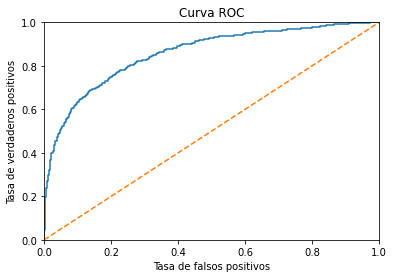

In [63]:
# Calculamos el AUC-ROC del modelo

probabilities_test = forest_model.predict_proba(x_test_ord)

probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(y_test, probabilities_one_test) 
print('AUC_ROC:', auc_roc)

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show() 

**Conclusiones:**

- Finlamente podemos concluir que para est problema el modelo mas adecuado fué un bosque aleatoreo. A pesar que presenta algo de sobreajuste, ha demostrado mayor flexibilidad al momento de clasificar los datos objetivos. 


- Hemos logrado mitigar el desbalanceo de clases utilizando el parámetro 'weightened' al momento de crear el  modelo y también con sobremuestreo, el sobremuestreo nos dió mejores resultados.


- A la final hemos conseguido un  modelo que al usar el conjunto de prueba arroja 0.63 en la métrica F1, sobrepasando el objetivo de 0.59.


- También se puede evaluar la calidad de nuestro modelo ya que el area por debajo de la curva ROC (0.857) es muy superior a la del modelo aleatorio (0.5).